In [66]:

import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
import poppy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))


import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi
import scoobi.utils as utils

import lina
print(scoobi.__file__)
print(lina.__file__)

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()
from magpyx.fdpr2 import console, tools

wavelength = 633e-9

/home/kianmilani/Projects/scoob-interface/scoobi/scoobi.py
/home/kianmilani/Projects/lina/lina/__init__.py


In [193]:
reload(scoobi)
xc, yc = (4780, 3580)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [52]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp03')
I.npsf = 256

# Do the normalization

In [194]:
reload(scoobi)
I.set_zwo_exp_time(0.000120, client0)

Set the ZWO exposure time to 1.20e-04s


In [54]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [195]:
reload(scoobi)
I.set_fib_atten(5, client)

Set the fiber attenuation to 5.0


In [204]:
scoobi.move_psf(5, 0, client0)

In [208]:
scoobi.move_psf(0, 2, client0)

In [26]:
reload(scoobi)
xc, yc = (4900, 3580)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

INFO:utils:Got semaphore index 1.


65532.0


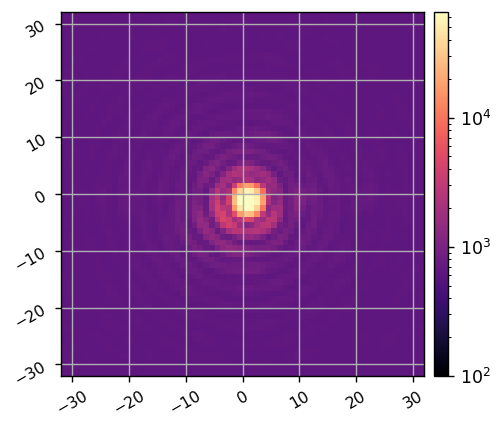

In [56]:
I.return_ni = False
I.NSCICAM = 20
I.x_shift = -20
I.y_shift = 2
psf = I.snap()

print(xp.max(psf))
imshow1(psf, lognorm=True, vmin=1e2, pxscl=1, grid=True, npix=64)

# Run FDPR with no added DM command

In [102]:
I.zero_dm()

In [103]:
# config_params = tools.Configuration('fdpr2_kilo_dmdiv')
config_params = tools.Configuration('fdpr2_kilo_dmdiv_km')
fitdict_ref, Imeas_cen = console.estimate_oneshot(config_params)


INFO:utils:Got semaphore index 1.
/opt/MagAOX/source/magpyx/magpyx/fdpr2/tools.py:536: RuntimeWarning: divide by zero encountered in log
  amp_lnrms = np.std(np.log(amp_norm)[amp_mask])#rms(np.log(amp_norm), pupil)
/opt/MagAOX/source/magpyx/magpyx/fdpr2/tools.py:124: RuntimeWarning: divide by zero encountered in log
  log_amp = np.log(amp)
INFO:fdpr2:Estimated phase RMS: 0.219 (rad)
INFO:fdpr2:Estimated amplitude RMS: 5.53 (%)
INFO:fdpr2:Estimated Strehl: 0.95 (0.95 phase-only and 1.00 amplitude-only)
INFO:fdpr2:Updated shmims fdpr2_phase and fdpr2_amp


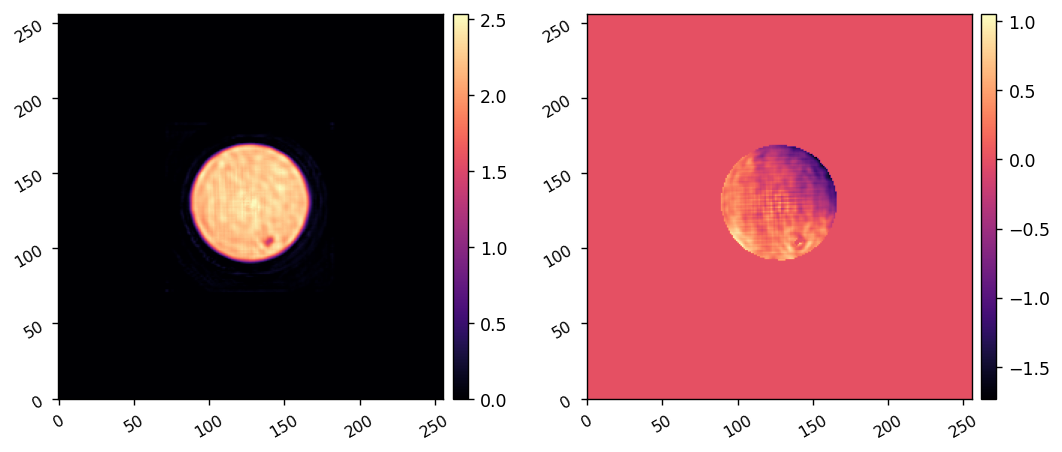

In [104]:
imshow2(fitdict_ref['amp_est'], fitdict_ref['phase_est'])

In [105]:
utils.save_pickle(f'data/{today}_fdpr2_fit_ref.pkl', fitdict_ref)

Saved data to:  data/20241028_fdpr2_fit_ref.pkl


# Now with the F command to test parity

In [106]:
F = lina.utils.make_f(h=10, w=6, shift=(0,0))
I.set_dm(20e-9 * F)

In [107]:
# config_params = tools.Configuration('fdpr2_kilo_dmdiv')
config_params = tools.Configuration('fdpr2_kilo_dmdiv_km')
fitdict_F, Imeas_cen = console.estimate_oneshot(config_params)

INFO:utils:Got semaphore index 1.
INFO:fdpr2:Estimated phase RMS: 0.24 (rad)
INFO:fdpr2:Estimated amplitude RMS: 6.13 (%)
INFO:fdpr2:Estimated Strehl: 0.94 (0.94 phase-only and 1.00 amplitude-only)
INFO:fdpr2:Updated shmims fdpr2_phase and fdpr2_amp


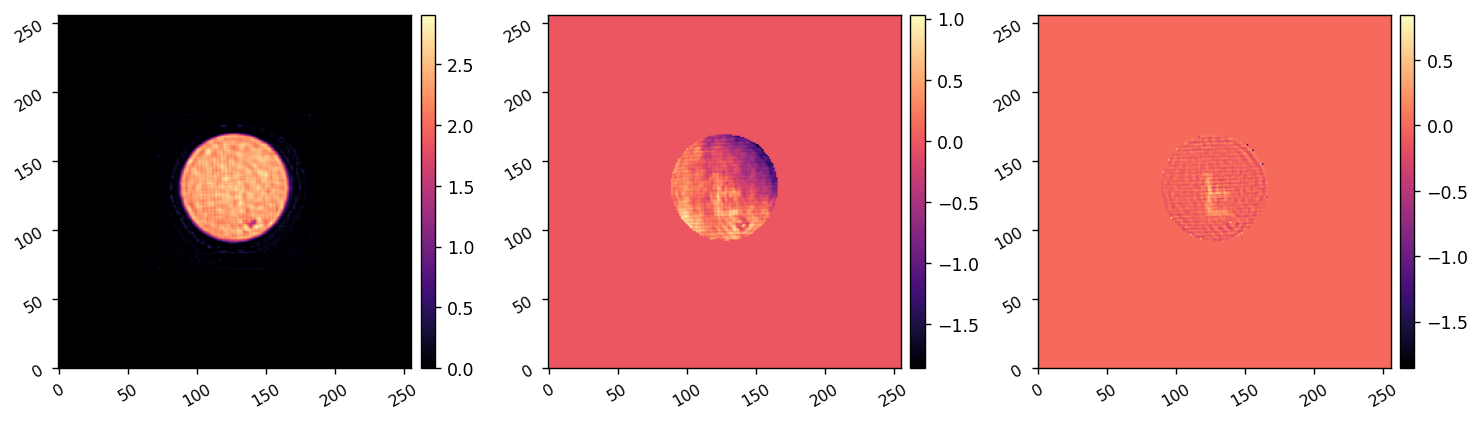

In [108]:
imshow3(fitdict_F['amp_est'], fitdict_F['phase_est'], fitdict_F['phase_est'] - fitdict_ref['phase_est'])

In [109]:
fitdict_F.update({'command':20e-9*F})
utils.save_pickle(f'data/{today}_fdpr2_fit_F.pkl', fitdict_F)

Saved data to:  data/20241028_fdpr2_fit_F.pkl


# Now with the ring command to test fill factor

In [122]:
rad = 13
ring = lina.utils.make_ring(rad=rad, Nact=34)
I.set_dm(20e-9 * ring)

In [123]:
# config_params = tools.Configuration('fdpr2_kilo_dmdiv')
config_params = tools.Configuration('fdpr2_kilo_dmdiv_km')
fitdict_ring, Imeas_cen = console.estimate_oneshot(config_params)

INFO:utils:Got semaphore index 1.
INFO:fdpr2:Estimated phase RMS: 0.235 (rad)
INFO:fdpr2:Estimated amplitude RMS: 6.09 (%)
INFO:fdpr2:Estimated Strehl: 0.94 (0.95 phase-only and 1.00 amplitude-only)
INFO:fdpr2:Updated shmims fdpr2_phase and fdpr2_amp


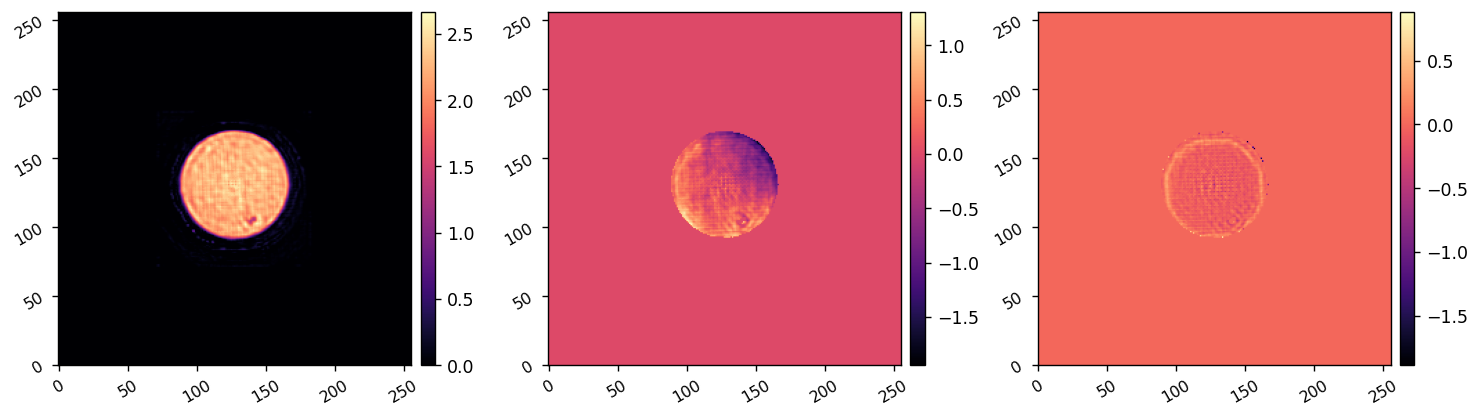

In [124]:
imshow3(fitdict_ring['amp_est'], fitdict_ring['phase_est'], fitdict_ring['phase_est'] - fitdict_ref['phase_est'])

In [125]:
fitdict_ring.update({'command':20e-9*ring})
utils.save_pickle(f'data/{today}_fdpr2_fit_ring_{rad}.pkl', fitdict_ring)

Saved data to:  data/20241028_fdpr2_fit_ring_13.pkl


# Now with the cross command to test orientation

In [182]:
reload(lina.utils)
cross = lina.utils.make_cross_command(xc=[-1, 3], yc=[2,-2])
I.set_dm(40e-9 * cross)

In [183]:
# config_params = tools.Configuration('fdpr2_kilo_dmdiv')
config_params = tools.Configuration('fdpr2_kilo_dmdiv_km')
fitdict_cross, Imeas_cen = console.estimate_oneshot(config_params)

INFO:utils:Got semaphore index 1.


/opt/MagAOX/source/magpyx/magpyx/fdpr2/tools.py:536: RuntimeWarning: divide by zero encountered in log
  amp_lnrms = np.std(np.log(amp_norm)[amp_mask])#rms(np.log(amp_norm), pupil)
/opt/MagAOX/source/magpyx/magpyx/fdpr2/tools.py:124: RuntimeWarning: divide by zero encountered in log
  log_amp = np.log(amp)
INFO:fdpr2:Estimated phase RMS: 0.323 (rad)
INFO:fdpr2:Estimated amplitude RMS: 6.7 (%)
INFO:fdpr2:Estimated Strehl: 0.90 (0.90 phase-only and 1.00 amplitude-only)
INFO:fdpr2:Updated shmims fdpr2_phase and fdpr2_amp


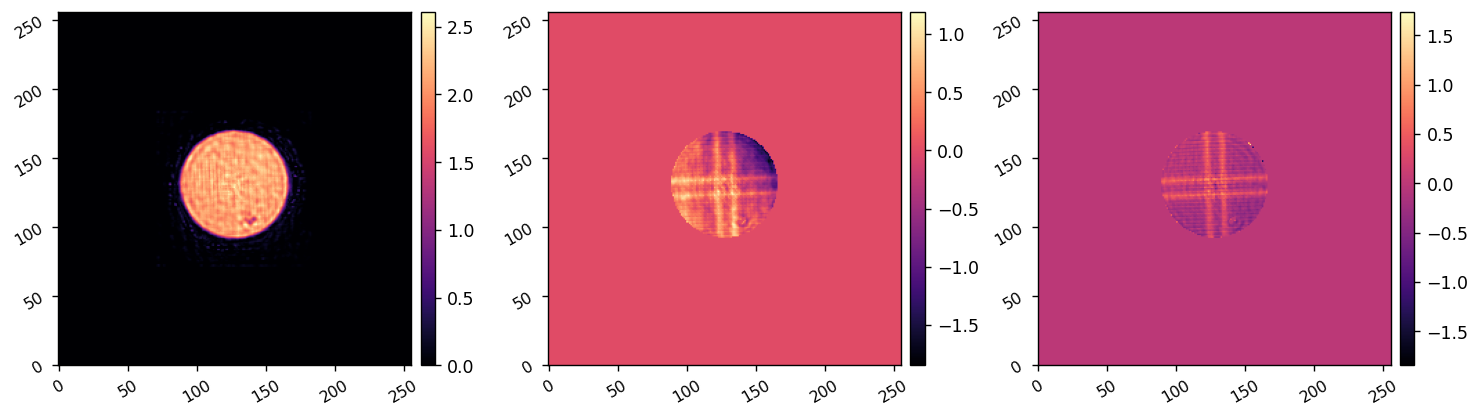

In [184]:
imshow3(fitdict_cross['amp_est'], fitdict_cross['phase_est'], fitdict_cross['phase_est'] - fitdict_ref['phase_est'])

In [186]:
fitdict_cross.update({'command':40e-9*cross})
utils.save_pickle(f'data/{today}_fdpr2_fit_cross.pkl', fitdict_cross)

Saved data to:  data/20241028_fdpr2_fit_cross.pkl


In [187]:
I.zero_dm()

# Now with combined ring commands to test registration. 

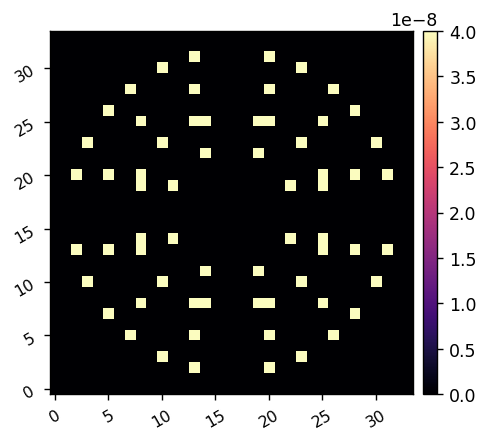

In [188]:
reload(lina.utils)
reg_command = lina.utils.make_ring(rad=15, thresh=1/10)
reg_command += lina.utils.make_ring(rad=12, thresh=1/10)
reg_command += lina.utils.make_ring(rad=9, thresh=1/5)
reg_command += lina.utils.make_ring(rad=6, thresh=1/6)
reg_command *= 40e-9
imshow1(reg_command)
I.set_dm(reg_command)

In [189]:
# config_params = tools.Configuration('fdpr2_kilo_dmdiv')
config_params = tools.Configuration('fdpr2_kilo_dmdiv_km')
fitdict_reg, Imeas_cen = console.estimate_oneshot(config_params)

INFO:utils:Got semaphore index 1.
/opt/MagAOX/source/magpyx/magpyx/fdpr2/tools.py:536: RuntimeWarning: divide by zero encountered in log
  amp_lnrms = np.std(np.log(amp_norm)[amp_mask])#rms(np.log(amp_norm), pupil)
/opt/MagAOX/source/magpyx/magpyx/fdpr2/tools.py:124: RuntimeWarning: divide by zero encountered in log
  log_amp = np.log(amp)
INFO:fdpr2:Estimated phase RMS: 0.244 (rad)
INFO:fdpr2:Estimated amplitude RMS: 6.42 (%)
INFO:fdpr2:Estimated Strehl: 0.94 (0.94 phase-only and 1.00 amplitude-only)
INFO:fdpr2:Updated shmims fdpr2_phase and fdpr2_amp


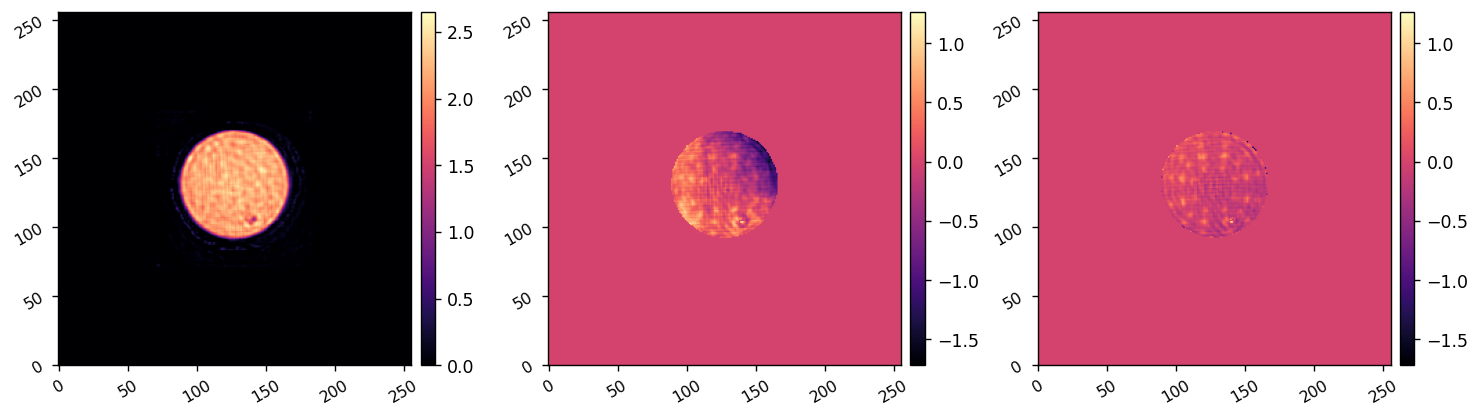

In [190]:
imshow3(fitdict_reg['amp_est'], fitdict_reg['phase_est'], fitdict_reg['phase_est'] - fitdict_ref['phase_est'])

In [191]:
fitdict_reg.update({'command':reg_command})
utils.save_pickle(f'data/{today}_fdpr2_fit_reg.pkl', fitdict_reg)

Saved data to:  data/20241028_fdpr2_fit_reg.pkl


In [192]:
I.zero_dm()